Allow for video splicing into images

In [7]:
import cv2

vidcap = cv2.VideoCapture('VLC_17062022.mp4')

success, image = vidcap.read()
count = 1
while success:
  cv2.imwrite("resources/image_%d.jpg" % count, image)    
  success, image = vidcap.read()
  print('Saved image ', count)
  count += 1

Saved image  1
Saved image  2
Saved image  3
Saved image  4
Saved image  5
Saved image  6
Saved image  7
Saved image  8
Saved image  9
Saved image  10
Saved image  11
Saved image  12
Saved image  13
Saved image  14
Saved image  15
Saved image  16
Saved image  17
Saved image  18
Saved image  19
Saved image  20
Saved image  21
Saved image  22
Saved image  23
Saved image  24
Saved image  25
Saved image  26
Saved image  27
Saved image  28
Saved image  29
Saved image  30
Saved image  31
Saved image  32
Saved image  33
Saved image  34
Saved image  35
Saved image  36
Saved image  37
Saved image  38
Saved image  39
Saved image  40
Saved image  41
Saved image  42
Saved image  43
Saved image  44
Saved image  45
Saved image  46
Saved image  47
Saved image  48
Saved image  49
Saved image  50
Saved image  51
Saved image  52
Saved image  53
Saved image  54
Saved image  55
Saved image  56
Saved image  57
Saved image  58
Saved image  59
Saved image  60
Saved image  61
Saved image  62
Saved image  63
S

Import libraries

In [8]:
from imutils import contours 
from skimage import measure  
import numpy as np          
import argparse
import imutils
import matplotlib.pyplot as plt

values = []

Allow image processing

In [20]:
circles = []

for i in range(100, 962):
    image_address = "./resources/image_" + str(i) + ".jpg"

    ## read the image
    image = cv2.imread(image_address)

    ## convert BGR to RGB, we won't use this in any of the processes, just to test image loading
    rgb_image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB) 

    ## convert BGR to greyscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    ## blur the image with a gussian filter to remove any noise, and also to soften the image
    blurred = cv2.GaussianBlur(gray, (11, 11), 0)

    # ## plot images in a nice array. We have to define the colormap for imshow to get a black and white image, as the default 
    # ## color map shows colors between yellow (pixel = 255) and black (pixel = 0)
    # fig , ax = plot_imshow_in_array([rgb_image , gray , blurred] , \
    #                                 max_image_in_row = 4 , \
    #                                 plots_kwargs_list = [{} , {'cmap':'gray', 'vmin':0, 'vmax':255} , {'cmap':'gray', 'vmin':0, 'vmax':255}] )

    # ## use this command to place enough spacing between the borders of images and the numbers
    # fig.tight_layout()

    thresh = cv2.threshold(blurred, 150, 255 , cv2.THRESH_BINARY)[1]

    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=4)

    MIN_ALLOWED_PIXEL_IN_REGION = 5000
    MAX_GREY_VALUE = 255

    ## find out regions and label them
    labels = measure.label(thresh, connectivity=2, background=0)


    ## The list holding all contiguous masks that will be found
    individual_masks = []

    ## loop over the unique components
    for label in np.unique(labels):
        # if this is the background (dark) label, ignore it
        if label == 0:
            continue
            
        # otherwise, construct the label mask and count the number of pixels 
        labelMask = np.zeros(thresh.shape, dtype="uint8")
        labelMask[labels == label] = MAX_GREY_VALUE
        numPixels = cv2.countNonZero(labelMask)

        
        # this condition filters "very" small regions
        if numPixels > MIN_ALLOWED_PIXEL_IN_REGION:
            #plt.figure()        
            individual_masks.append(labelMask)
    
    ## make a copy of the individual_mask to avoid them from being overwritten
    individual_masks_cp = [mask.copy() for mask in individual_masks]

    value = 0
    max_circle = 0

    for idx , current_mask in enumerate(individual_masks_cp):
        cnts = cv2.findContours(current_mask.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
    #     cnts = contours.sort_contours(cnts)[0]

        ## create a mask to hold the values of the enclosing circle, we also fill inside the cirlce. 
        filled_circle = np.zeros(current_mask.shape)

        ## find the coordinates of the center and the radius of the circle
        ((cX, cY), radius) = cv2.minEnclosingCircle(cnts[0])
        
        ## fill the mask values surrounded by the circle
        cv2.circle(filled_circle, (int(cX), int(cY)), int(radius),(255, 255, 255), -1)
        
        ## count the number of pixels in the circle
        circle_area = cv2.countNonZero(filled_circle)
        
        ## count the number of non-zero pixels in the original region
        mask_non_zero_area = cv2.countNonZero(individual_masks[idx])
        
        ## plot the circle and the region, and show the filled ratio in each circle
        # plot_imshow_in_array([filled_circle , individual_masks[idx]] , max_image_in_row = 4)

        if ((mask_non_zero_area / circle_area) > 0.9):
            value = 1

        if ((mask_non_zero_area / circle_area) > max_circle):
            max_circle = mask_non_zero_area / circle_area

        #plt.title("circles' filled ratio = {:.2}".format(mask_non_zero_area / circle_area))

    values.append(value)
    circles.append(max_circle)

[0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.6536363705908003, 0.9446251309211335, 0.9686912053387252, 0, 0.7474359060245322, 0.9606512949789047, 0.9775469029011387, 0, 0.7581062146000671, 0.9600719918787487, 0.9801843122666076, 0, 0.7763916972989735, 0.9511479318883556, 0.9789191934052479, 0, 0.8495152530014768, 0.9553109299988836, 0.9798276958990476, 0, 0.8898097266722752, 0.959446243161773, 0.9791402513352491, 0, 0.9338098990368535, 0.9538145454705435, 0.9795036052531574, 0, 0.9677752781662309, 0.9688634807799544, 0.9842609772719358, 0, 0.964666368356075, 0.9607502512001787, 0.9857121754677288, 0, 0.9649030359630405, 0.9641085184771687, 0.9826712559198778, 0, 0.9628302392228416,

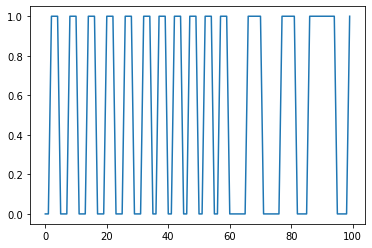

In [43]:
rising = 0
falling = 0

start = 0

result = []

for i in range(0, len(circles) - 1):
    if (circles[i] > 0.3):
        start = i
        result.append(0)
        break

for i in range(start, len(circles) - 1):
    if (circles[i] > 0.9):
        if (falling > rising):
            result.append(1)
        result.append(1)
    elif (circles[i] < 0.1):
        if (rising > falling):
            result.append(0)
        result.append(0)
    else:
        if (result[-1] == 0):
            rising = i
            result.append(0)
            result.append(1)
        else:
            falling = i
            result.append(1)
            result.append(0)

print(result[0:100])
print(circles[0:100])

plt.plot(result[0:100])
plt.show()

# for i in range(0, len(values)-1):
#     if (last == 0):
#         if (values[i] > 0.9):
#             if (switch_index != 0):
#                 switched.append(i - switch_index)
#             switch_index = i
#             last = 1
#     else:
#         if (values[i] < 0.1):
#             if (switch_index != 0):
#                 switched.append(i - switch_index)
#             last = 0
#             switch_index = i

#     # if (abs(last - circles[i]) > 0.5):
#     #     # switch
#     #     switched.append(i - switch_index)
#     #     switch_index = i
#     #     last = circles[i]

# print(switched)

# plt.plot(circles[0:100])
# plt.show()

Allow demodulation

Original:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0

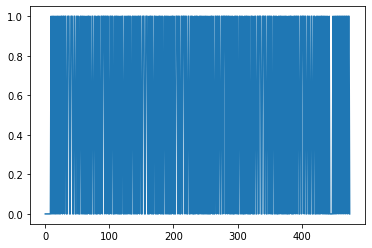

In [10]:
# 0xAAAA 1010101010101010

data = values.copy()

def demodulate(bits):
    result = 0
    for i in range(0, 16):
        if (i % 2 == 0):
            if (np.array_equal(np.array(bits[i:i+2]), np.array([0, 1]))):
                result = result | (1 << (i // 2))
        else:
            continue 
    return result

preamble = np.array([1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0])
found = False
start = -1
while ((not found) and (len(data) > 1)):
    for i in range(0, len(data)-16):
        if (np.array_equal(preamble, np.array(data[i:i+16]))):
            found = True
            start = i
            print("Found at ", str(i))
            break
    if (not found):
        values2 = []
        a = False
        for x in range(0, len(data)-1):
            if ((x != (len(data)-1)) and (data[x] == data[x+1]) and (not a)):
                a = True
                continue
            values2.append(data[x])
            a = False
        print("Original: ", data)
        data = values2
        print("New: ", values2)

print(data[start+16:start+32])
print(demodulate(data[start+16:start+32]))

plt.plot(data)
plt.show()